In [2]:
import pandas as pd
import numpy as np
from requests import get
from bs4 import BeautifulSoup
from time import sleep, time
from random import randint
from IPython.core.display import clear_output
from warnings import warn

pd.set_option("display.max_colwidth",-1)

In [ ]:
begin_year = 2006
end_year = 2018

for i in range(end_year-begin_year):
    begin_year += 1
    %reset_selective -f df

    ##############################################################

    names = []
    episode = []
    years = []
    imdb_ratings = []
    metascores = []
    votes = []
    gross_revenue = []
    types = []
    genre = []
    length = []
    stars = []
    director = []
    img_html = []

    # Preparing the monitoring of the loop
    start_time = time()
    requests = 0
    pages = [str(i) for i in range(1,9902,50)] 
    years_url = [str(i) for i in range(begin_year,begin_year+1)]
    headers = {"Accept-Language": "en-US, en;q=0.5"}

    # For every year
    for year_url in years_url:
        print(year_url)
        # For every page
        for page in pages:
            print("page =",page)
            # Make a get request
            # response = get('http://www.imdb.com/search/title?release_date=' + year_url + '&sort=num_votes,desc&page=' + page, headers = headers)
            response = get('https://www.imdb.com/search/title?release_date=' + year_url + '-01-01,' + year_url + '-12-31&sort=num_votes,desc&start=' + page + '&ref_=adv_nxt')

            # Pause the loop
            sleep(1)
            '''
            # Monitor the requests
            requests += 1
            elapsed_time = time() - start_time
            print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
            clear_output(wait = True)

            # Throw a warning for non-200 status codes
            if response.status_code != 200:
                warn('Request: {}; Status code: {}'.format(requests, response.status_code))

            # Break the loop if the number of requests is greater than expected
            if requests > 100000:
                warn('Number of requests was greater than expected.')  
                break 
            '''
            # Parse the content of the request with BeautifulSoup
            page_html = BeautifulSoup(response.text, 'html.parser')

            # Select all the 50 movie containers from a single page
            mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

            # For every movie of these 50
            for mv_container in mv_containers:

                # Scrape the Name
                containers = mv_container.find_all('h3', class_ = 'lister-item-header')
                for container in containers:
                    sub_containers = container.find_all('a')
                    if len(sub_containers)==1:
                        names.append(sub_containers[0].text)
                    else:
                        names.append(sub_containers[0].text + ' - episode ' + sub_containers[1].text)

                '''
                # Scrape the Year 
                year = mv_container.h3.find('span', class_ = 'lister-item-year').text
                if year == None:
                    years.append(np.nan)
                else:
                    years.append(year)
                '''
                # Year
                years.append(year_url)


                # Scrape the IMDB rating
                imdb = mv_container.strong
                if imdb == None:
                    imdb_ratings.append(np.nan)
                else:
                    imdb_ratings.append(float(imdb.text))

                # Scrape the Metascore
                m_score = mv_container.find('span', class_ = 'metascore')
                if m_score == None:
                    metascores.append(np.nan)
                else:
                    metascores.append(int(m_score.text))

                # Scrape the number of votes
                vote = mv_container.find('span', attrs = {'name':'nv'})
                if vote == None:
                    votes.append(np.nan)
                else:
                    votes.append(int(vote['data-value']))

                # Scrape gross revenue
                containers = mv_container.find_all('span', attrs = {'name':'nv'})
                if len(containers) < 2:
                    gross_revenue.append(np.nan)
                else:
                    gross_revenue.append(containers[1].text)

                # Scrape the Length
                runtime = mv_container.find('span', class_ = 'runtime')
                if runtime == None:
                    length.append(np.nan)
                else:
                    length.append(runtime.text)

                # Scrape the Type
                type = mv_container.find('span', class_ = 'certificate')
                if type == None:
                    types.append(np.nan)
                else:
                    types.append(type.text)

                # Scrape the Genre
                _genre = mv_container.find('span', class_ = 'genre')
                if _genre == None:
                    genre.append(np.nan)
                else:
                    genre.append(_genre.text.strip('\n'))

                # Scrape the Stars
                _soup_stars = mv_container.find('div',class_='lister-item-content').text
                begin = _soup_stars.find("Stars")
                end = _soup_stars.find("Votes")
                _stars = _soup_stars[begin+6:end].strip('\n')
                _stars = _stars.replace('\n','')
                stars.append(_stars)

                # Scrape the Director
                _soup_director = mv_container.find('div',class_='lister-item-content').text
                begin = _soup_director.find("Director")
                end = _soup_director.find("Stars")
                _director = _soup_director[begin+9:end].strip('\n')
                _director = _director.replace('|','')
                _director = _director.replace(':','')
                _director = _director.replace('\n','')
                director.append(_director)

                # Scrape the Thumb
                _soup_img = mv_container.find('div',class_='lister-item-image float-left')
                img = _soup_img.find("img")
                src = img["loadlate"]
                _img_html = f'<img src="{src}" />'
                img_html.append(_img_html)

        df = pd.DataFrame({'movie': names,
                       'year': years,
                       'imdb': imdb_ratings,
                       'metascore': metascores,
                       'gross_revenue': gross_revenue,
                       'vote': votes,
                      'type': types,
                       'length': length,
                      'genre': genre,
                      'stars': stars,
                      'director': director,
                      'img_html': img_html})

        df['year'] = year_url
        df['gross_revenue'] = df['gross_revenue'].str.replace('$','')
        df['gross_revenue'] = df['gross_revenue'].str.replace('M','').astype('float64')

        _stars = list(df.stars)
        new_stars = []

        for s in _stars:
            gather = []
            for i in range(1,10,1):
                var = s.find(str(i))
                gather.append(var)

            sum = 1
            for element in gather:
                sum = sum*element

            if sum != -1:
                new_stars.append(np.nan)
            else:
                new_stars.append(s)

        df['stars'] = new_stars

        _director = list(df.director)
        new_director = []

        for s in _director:
            gather = []
            for i in range(1,10,1):
                var = s.find(str(i))
                gather.append(var)

            sum = 1
            for element in gather:
                sum = sum*element

            if sum != -1:
                new_director.append(np.nan)
            else:
                new_director.append(s)

        df['director'] = new_director

    df.to_csv('C:/Users/USER/Desktop/IMDB_raw/IMDB_' + str(year_url) + '_new.csv', index=False)
    %reset_selective -f df
    print('done....writing a csv file')
                
print("--- Done ---")

In [ ]:
from IPython.display import HTML, display, Image
from IPython.core.display import display, HTML, Image

HTML(df[:50].to_html(escape=False))

In [3]:
# Merge all
import pandas as pd

_1975 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1975.csv')
_1976 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1976.csv')
_1977 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1977.csv')
_1978 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1978.csv')
_1979 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1979.csv')
_1980 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1980.csv')
_1981 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1981.csv')
_1982 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1982.csv')
_1983 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1983.csv')
_1984 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1984.csv')
_1985 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1985.csv')
_1986 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1986.csv')
_1987 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1987.csv')
_1988 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1988.csv')
_1989 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1989.csv')
_1990 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1990.csv')
_1991 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1991.csv')
_1992 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1992.csv')
_1993 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1993.csv')
_1994 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1994.csv')
_1995 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1995.csv')
_1996 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1996.csv')
_1997 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1997.csv')
_1998 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1998.csv')
_1999 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_1999.csv')
_2000 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2000.csv')
_2001 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2001.csv')
_2002 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2002.csv')
_2003 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2003.csv')
_2004 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2004.csv')
_2005 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2005.csv')
_2006 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2006.csv')
_2007 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2007.csv')
_2008 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2008.csv')
_2009 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2009.csv')
_2010 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2010.csv')
_2011 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2011.csv')
_2012 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2012.csv')
_2013 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2013.csv')
_2014 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2014.csv')
_2015 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2015.csv')
_2016 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2016.csv')
_2017 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2017.csv')
_2018 = pd.read_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_2018.csv')

In [4]:
df_all = _1975.append(_1976)
df_all = df_all.append(_1977)
df_all = df_all.append(_1978)
df_all = df_all.append(_1979)
df_all = df_all.append(_1980)
df_all = df_all.append(_1981)
df_all = df_all.append(_1982)
df_all = df_all.append(_1983)
df_all = df_all.append(_1984)
df_all = df_all.append(_1985)
df_all = df_all.append(_1986)
df_all = df_all.append(_1987)
df_all = df_all.append(_1988)
df_all = df_all.append(_1989)
df_all = df_all.append(_1990)
df_all = df_all.append(_1991)
df_all = df_all.append(_1992)
df_all = df_all.append(_1993)
df_all = df_all.append(_1994)
df_all = df_all.append(_1995)
df_all = df_all.append(_1996)
df_all = df_all.append(_1997)
df_all = df_all.append(_1998)
df_all = df_all.append(_1999)
df_all = df_all.append(_2000)
df_all = df_all.append(_2001)
df_all = df_all.append(_2002)
df_all = df_all.append(_2003)
df_all = df_all.append(_2004)
df_all = df_all.append(_2005)
df_all = df_all.append(_2006)
df_all = df_all.append(_2007)
df_all = df_all.append(_2008)
df_all = df_all.append(_2009)
df_all = df_all.append(_2010)
df_all = df_all.append(_2011)
df_all = df_all.append(_2012)
df_all = df_all.append(_2013)
df_all = df_all.append(_2014)
df_all = df_all.append(_2015)
df_all = df_all.append(_2016)
df_all = df_all.append(_2017)
df_all = df_all.append(_2018)

#df_all['year'] = df_all['year'].astype('object')
#df_all['duration_(min)'] = df_all['duration_(min)'].str.replace(',','')
#df_all['duration_(min)'] = df_all['duration_(min)'].astype('float64')
df_all.drop_duplicates(['movie'],keep='last',inplace=True)

df_all.to_csv('C:/Users/USER/Desktop/IMDB_cleaned/imdb_cleaned_all.csv',index=False)

In [7]:
from IPython.display import HTML, display, Image
from IPython.core.display import display, HTML, Image

HTML(df[:50].to_html(escape=False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358721 entries, 0 to 9628
Data columns (total 12 columns):
year              358721 non-null object
movie             358721 non-null object
type              358721 non-null object
imdb              340425 non-null float64
metascore         12363 non-null float64
vote              340425 non-null float64
duration_(min)    184315 non-null float64
gross_revenue     12771 non-null float64
genre             358721 non-null object
director          358721 non-null object
stars             358721 non-null object
img_html          358721 non-null object
dtypes: float64(5), object(7)
memory usage: 35.6+ MB


In [8]:
df_all['type'].unique()

array(['unrated', 'PG-13', 'NC-17', 'R', 'PG', 'Not Rated', '(Banned)',
       'G', 'Unrated', 'R-14', '18', '13', 'TV-14', '15', '20', 'TV-PG',
       'PD-14'], dtype=object)

In [9]:
events = pd.read_csv("C:/Users/USER/Desktop/IMDB_cleaned/Major_Events.csv")
events.shape

(78, 2)

In [12]:
oscar = pd.read_csv("C:/Users/USER/Desktop/IMDB_cleaned/oscars-nominees-and-winners/data/oscar_nominated.csv")
oscar.head()

,entity,winner,isOscarNominated?
0,TITANIC,10,YES
1,LA LA LAND,10,YES
2,LIFE OF PI,9,YES
3,THE REVENANT,9,YES
4,MAD MAX: FURY ROAD,9,YES


In [22]:
df.columns

Index(['type', 'imdb', 'metascore', 'vote', 'duration_(min)', 'gross_revenue',
       'genre_1', 'director_1', 'stars_1', 'isOscarNominated?', 'movie'],
      dtype='object')

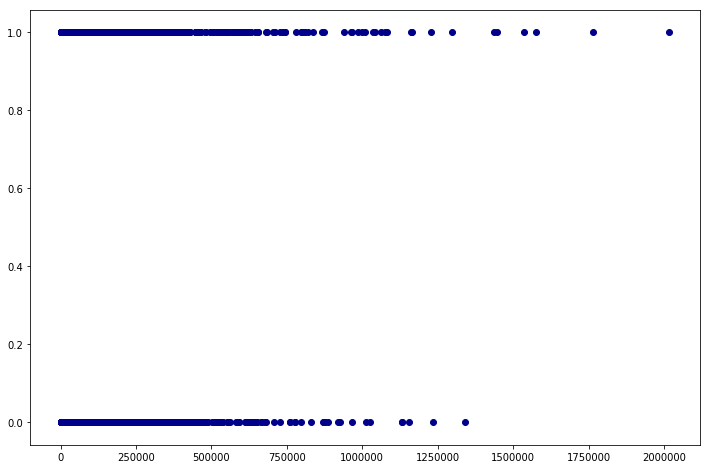

In [30]:
import matplotlib.pyplot as plt
df = pd.read_csv("C:/Users/USER/Desktop/IMDB_cleaned/imdb_and_oscar.csv")
df.head()

plt.figure(figsize=(12,8))
plt.scatter(x=df['vote'],y=df['isOscarNominated?'],c='DarkBlue')
plt.show()

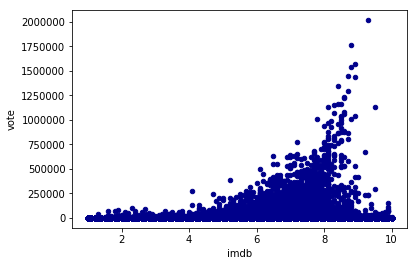

In [18]:
import matplotlib.pyplot as plt
df_all.plot.scatter(x='imdb',y='vote',c='DarkBlue')
plt.show()

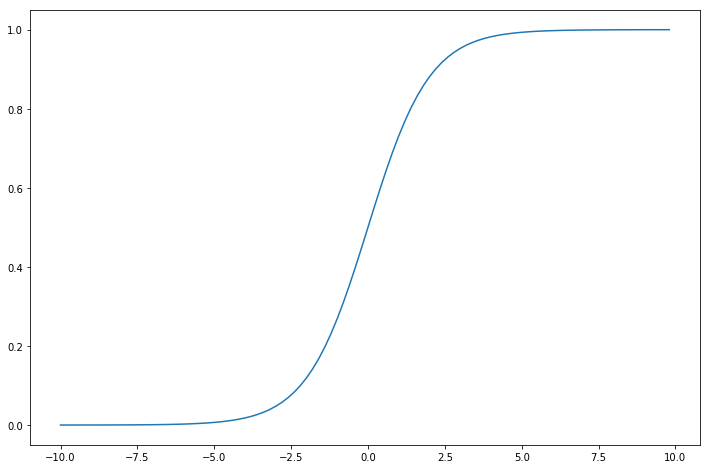

In [36]:
import math
import numpy as np

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)

plt.figure(figsize=(12,8))
plt.plot(x,sig)
plt.show()